In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

from IPython.display import Image  # 주피터 노트북에 이미지 삽입

In [25]:
#plt에 한글
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [26]:
distribution_centers = pd.read_csv('data/distribution_centers.csv')
events = pd.read_csv('data/events.csv')
inventory_items = pd.read_csv('data/inventory_items.csv')
order_items = pd.read_csv('data/order_items.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
users = pd.read_csv('data/users.csv')

In [27]:
# events.head()
events.shape

(2431963, 13)

### 퍼널 분석 

In [29]:
events['event_type'].value_counts()
#product -> cart -> purchase 순

event_type
product       845607
cart          595994
department    595323
purchase      181759
cancel        125568
home           87712
Name: count, dtype: int64

In [30]:
# 퍼널 단계 정의
funnel_stages = ['product', 'cart', 'purchase']

In [31]:
#퍼널 데이터 준비
event_values = events['event_type'].value_counts().reset_index()
funnel_data = event_values[event_values['event_type'].isin(funnel_stages)].sort_values('count', ascending = False)

In [32]:
funnel_data['conversion_rate'] = funnel_data['count'] / funnel_data['count'].shift(1)

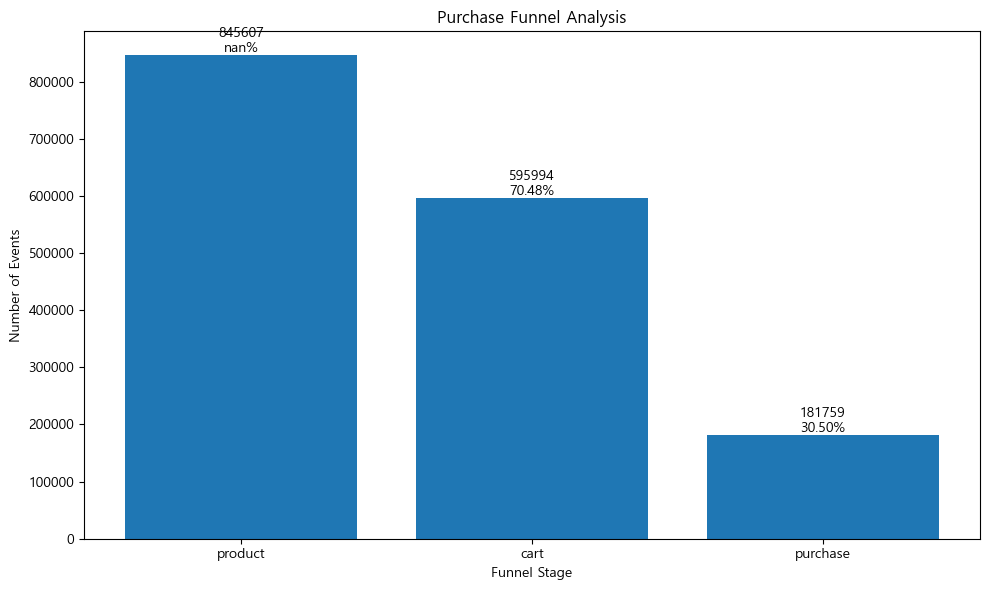

In [33]:
# 퍼널 시각화
plt.figure(figsize=(10, 6))
plt.bar(funnel_data['event_type'], funnel_data['count'])
plt.title('Purchase Funnel Analysis')
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Events')

for i, (count,rate) in enumerate(zip(funnel_data['count'], funnel_data['conversion_rate'])):
    plt.text(i, count, f'{count}\n{rate:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 그룹별 퍼널 분석

In [34]:
def perform_funnel_analysis(df, group_by):
    grouped = df.groupby([group_by, 'event_type']).size().unstack()
    grouped = grouped.reindex(columns = funnel_stages)

    #전환율 계산
    grouped['product_to_cart'] = grouped['cart']/grouped['product']
    grouped['cart_to_purchase'] = grouped['purchase']/grouped['cart']
    grouped['overall_conversion'] = grouped['purchase']/grouped['product']
    return grouped

In [35]:
grouped = events.groupby(['browser', 'event_type']).size().unstack()
grouped.reindex(columns = funnel_stages)

event_type,product,cart,purchase
browser,,,
Chrome,423550,298625,91377
Firefox,169463,119560,36457
IE,42398,29695,8957
Other,41915,29510,9036
Safari,168281,118604,35932


In [36]:
browser_funnel = perform_funnel_analysis(events, 'browser')

<Figure size 1000x600 with 0 Axes>

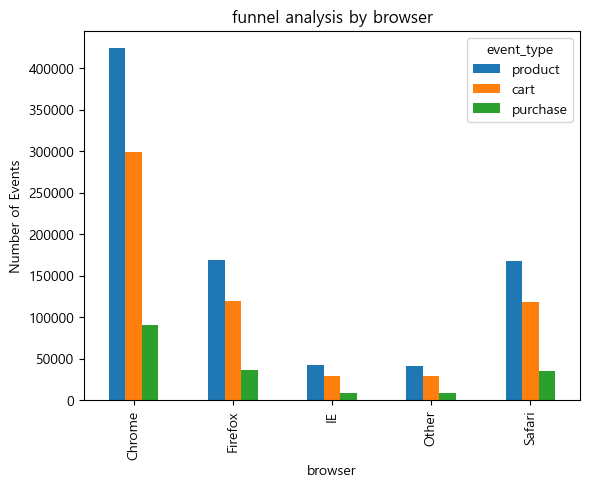

In [37]:
plt.figure(figsize=(10, 6))
browser_funnel[funnel_stages].plot(kind = 'bar')
plt.title('funnel analysis by browser')
plt.xlabel('browser')
plt.ylabel('Number of Events')
plt.show()

In [38]:
browser_funnel = browser_funnel.drop(columns = funnel_stages).reset_index()

In [39]:
browser_funnel_melted = browser_funnel.melt(id_vars=['browser'], var_name='conversion_type', value_name='rate')

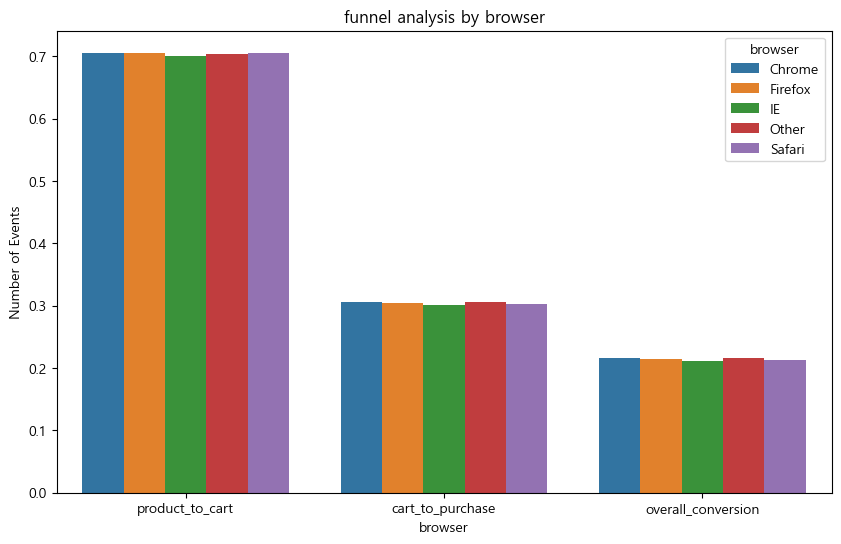

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'conversion_type', y ='rate', hue = 'browser', data = browser_funnel_melted)
plt.title('funnel analysis by browser')
plt.xlabel('browser')
plt.ylabel('Number of Events')
plt.show()

In [41]:
traffic_source_funnel = perform_funnel_analysis(events, 'traffic_source')

In [42]:
traffic_source_funnel

event_type,product,cart,purchase,product_to_cart,cart_to_purchase,overall_conversion
traffic_source,,,,,,
Adwords,254290,179281,54542,0.705026,0.304226,0.214487
Email,379736,267411,81706,0.704202,0.305545,0.215165
Facebook,84523,59962,18305,0.709416,0.305277,0.216568
Organic,42520,29822,9124,0.701364,0.305949,0.214581
YouTube,84538,59518,18082,0.704038,0.303807,0.213892


In [43]:
traffic_source_funnel = traffic_source_funnel.drop(columns = funnel_stages).reset_index()

In [44]:
traffic_source_funnel_melted = traffic_source_funnel.melt(id_vars=['traffic_source'], var_name='conversion_type', value_name='rate')

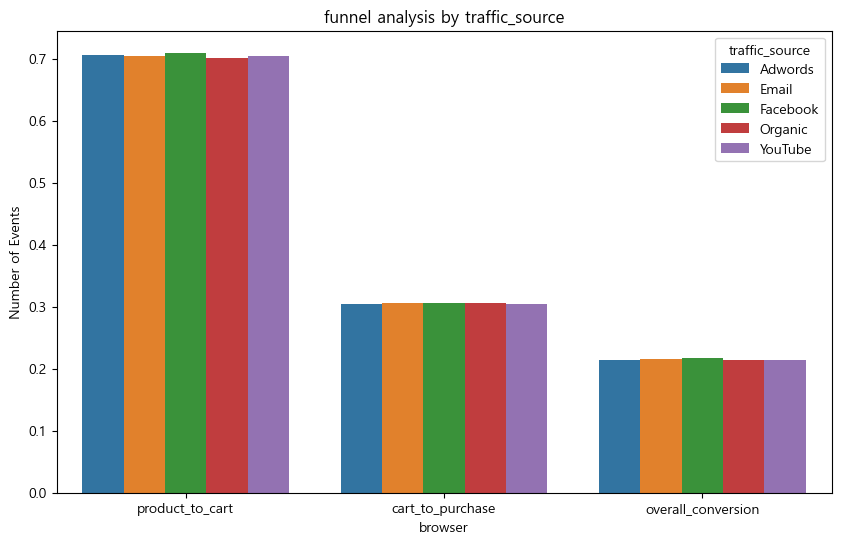

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(x = 'conversion_type', y ='rate', hue = 'traffic_source', data = traffic_source_funnel_melted)
plt.title('funnel analysis by traffic_source')
plt.xlabel('browser')
plt.ylabel('Number of Events')
plt.show()

### 리텐션 분석

In [46]:
# datetime 형식으로 변환
events['created_at'] = pd.to_datetime(events['created_at'], errors= 'coerce')
users['created_at'] = pd.to_datetime(users['created_at'], errors= 'coerce')

In [47]:
first_use = users.groupby('id')['created_at'].min().reset_index()
first_use.columns = ['user_id', 'first_use_date']
events = events.merge(first_use, on='user_id')

In [48]:
# 주간 리텐션
# 게임/스트리밍 서비스/유튜브/웹툰 등은 사람들이 매일 들어와야 관성이 생겨서 이탈할 확률이 적음
# 쇼핑은 주/월 단위로 하는 사람들이 많을 것이기 때문에 주간/월간 리텐션을 보는 것이 중요 -> 그래서 우리는 주간 리텐션부터 시작

events['week_number'] = ((events['created_at'] - events['first_use_date']).dt.days // 7)

In [49]:
events.head()

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type,first_use_date,week_number
0,458138,35092.0,3,e24636ad-3949-4174-bd09-4e2ae7a95aa3,2022-08-01 01:10:20+00:00,92.212.103.243,Sapporo,Hokkaido,003-0030,Chrome,Facebook,/cart,cart,2022-05-22 02:33:00+00:00,10.0
1,444176,34028.0,6,b334f6d8-a1fd-42e9-90e4-8e8d2af7a663,2021-07-13 23:14:04+00:00,176.14.231.160,Sapporo,Hokkaido,007-0890,Safari,Email,/cart,cart,2020-02-20 01:20:00+00:00,72.0
2,170896,13199.0,4,1df890d5-6783-4602-aa0a-e6668fed606e,2023-11-05 10:45:45+00:00,114.185.130.47,São Paulo,São Paulo,02220-000,Safari,Email,/cart,cart,2021-08-27 13:52:00+00:00,114.0
3,1147243,87818.0,3,e99fd570-3c66-4475-ab68-41c4a0da4bbc,2021-01-01 06:55:11+00:00,138.36.176.82,São Paulo,São Paulo,02675-031,Chrome,Email,/cart,cart,2020-05-26 07:42:00+00:00,31.0
4,604658,46234.0,3,d566d275-4aea-4e90-be87-f119b4369f48,2023-12-22 12:38:20+00:00,163.100.101.188,São Paulo,São Paulo,02675-031,Safari,Adwords,/cart,cart,2023-05-22 15:22:00+00:00,30.0


In [50]:
# 10주차까지만 데이터 유지
events_10 = events[(events['week_number'] <= 10) & (events['week_number'] >= 0)]

In [51]:
#weekly retention(주간 잔존율)

retention_data = events_10.groupby(['user_id', 'week_number'])['created_at'].count().reset_index()

In [52]:
retention_data.head()

,user_id,week_number,created_at
0,3.0,0.0,5
1,3.0,3.0,14
2,3.0,6.0,5
3,6.0,5.0,13
4,6.0,6.0,1


In [53]:
retention_data = retention_data.pivot(index = 'user_id', columns = 'week_number', values = 'created_at')


In [54]:
retention_data = retention_data.applymap(lambda x:1 if x > 0 else 0)

C:\Users\hyunj\AppData\Local\Temp\ipykernel_42352\1572732622.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  retention_data = retention_data.applymap(lambda x:1 if x > 0 else 0)


In [55]:
retention_data.head()

week_number,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
user_id,,,,,,,,,,,
3.0,1,0,0,1,0,0,1,0,0,0,0
6.0,0,0,0,0,0,1,1,0,0,0,0
8.0,0,0,0,0,1,0,0,0,0,0,0
11.0,0,0,0,0,1,0,0,0,0,0,0
12.0,0,0,0,0,0,0,0,0,0,1,0


In [56]:
retention_rates = retention_data.mean()

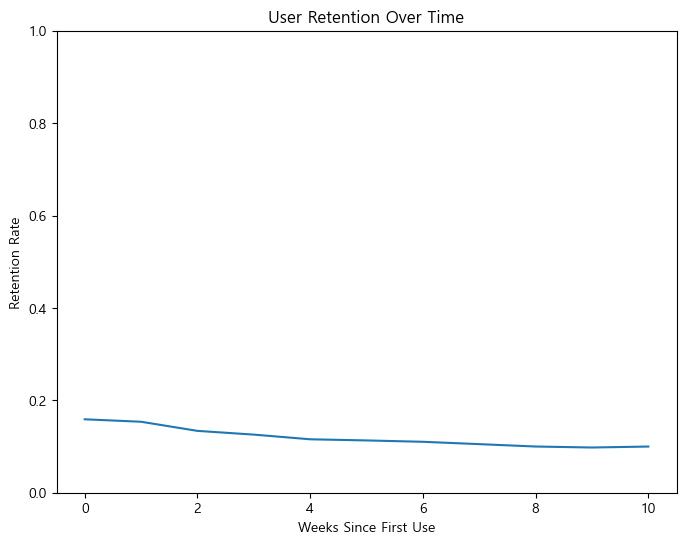

In [57]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=retention_rates.index, y=retention_rates.values)
plt.title('User Retention Over Time')
plt.xlabel('Weeks Since First Use')
plt.ylabel('Retention Rate')
plt.ylim(0, 1)
plt.show()



In [58]:
retention_rates.reset_index()

,week_number,0
0,0.0,0.158935
1,1.0,0.153620
2,2.0,0.133861
3,3.0,0.125773
4,4.0,0.115662
5,5.0,0.113178
6,6.0,0.110232
7,7.0,0.105148
8,8.0,0.100006
9,9.0,0.097868


#### 월별 1주차 리텐션 변화 추이

In [59]:
events['first_use_month'] = events['first_use_date'].dt.to_period('M')

C:\Users\hyunj\AppData\Local\Temp\ipykernel_42352\2430176798.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  events['first_use_month'] = events['first_use_date'].dt.to_period('M')


In [60]:
events.head()

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type,first_use_date,week_number,first_use_month
0,458138,35092.0,3,e24636ad-3949-4174-bd09-4e2ae7a95aa3,2022-08-01 01:10:20+00:00,92.212.103.243,Sapporo,Hokkaido,003-0030,Chrome,Facebook,/cart,cart,2022-05-22 02:33:00+00:00,10.0,2022-05
1,444176,34028.0,6,b334f6d8-a1fd-42e9-90e4-8e8d2af7a663,2021-07-13 23:14:04+00:00,176.14.231.160,Sapporo,Hokkaido,007-0890,Safari,Email,/cart,cart,2020-02-20 01:20:00+00:00,72.0,2020-02
2,170896,13199.0,4,1df890d5-6783-4602-aa0a-e6668fed606e,2023-11-05 10:45:45+00:00,114.185.130.47,São Paulo,São Paulo,02220-000,Safari,Email,/cart,cart,2021-08-27 13:52:00+00:00,114.0,2021-08
3,1147243,87818.0,3,e99fd570-3c66-4475-ab68-41c4a0da4bbc,2021-01-01 06:55:11+00:00,138.36.176.82,São Paulo,São Paulo,02675-031,Chrome,Email,/cart,cart,2020-05-26 07:42:00+00:00,31.0,2020-05
4,604658,46234.0,3,d566d275-4aea-4e90-be87-f119b4369f48,2023-12-22 12:38:20+00:00,163.100.101.188,São Paulo,São Paulo,02675-031,Safari,Adwords,/cart,cart,2023-05-22 15:22:00+00:00,30.0,2023-05


In [61]:
events_one_week = events[events['week_number'] == 1]

In [62]:
# 각각의 월별로 (1주차 이벤트 이력 있는 유저) / (해당 월 신규 가입 전체 유저) -> 월별 1주 리텐션이 만들어 짐
w1_retention_rates_monthly = events_one_week.groupby('first_use_month').nunique()['user_id'] / events.groupby('first_use_month').nunique()['user_id']

In [63]:
w1_retention_rates_monthly.tail()

first_use_month
2023-09    0.100853
2023-10    0.137209
2023-11    0.184190
2023-12    0.413374
2024-01    0.267908
Freq: M, Name: user_id, dtype: float64

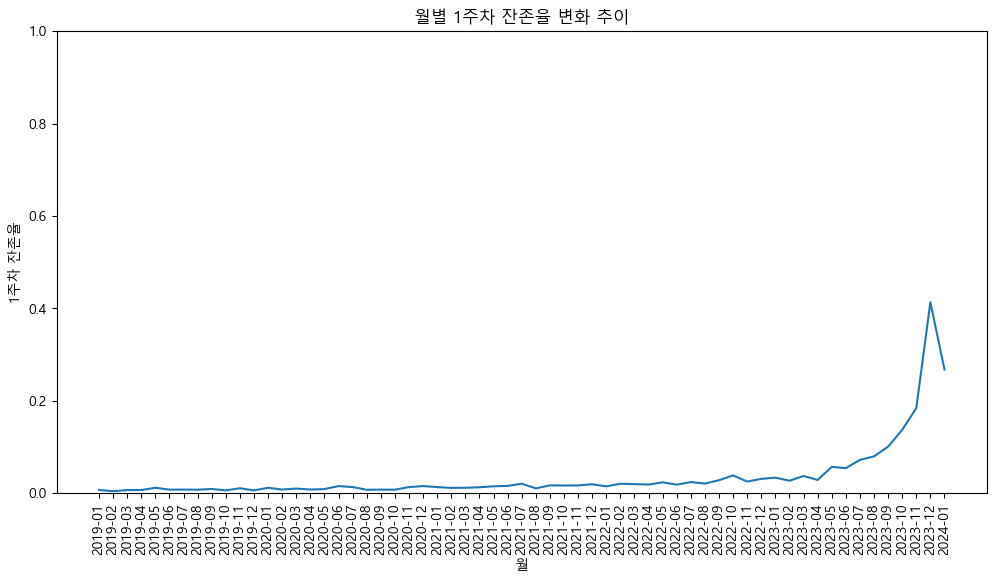

In [46]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=w1_retention_rates_monthly.index.astype(str), y=w1_retention_rates_monthly.values)
plt.title('월별 1주차 잔존율 변화 추이')
plt.xlabel('월')
plt.ylabel('1주차 잔존율')
plt.xticks(rotation = 90)
plt.ylim(0, 1)
plt.show()



### 코호트 분석

In [47]:
events.head()

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type,first_use_date,week_number,first_use_month
0,458138,35092.0,3,e24636ad-3949-4174-bd09-4e2ae7a95aa3,2022-08-01 01:10:20+00:00,92.212.103.243,Sapporo,Hokkaido,003-0030,Chrome,Facebook,/cart,cart,2022-05-22 02:33:00+00:00,10.0,2022-05
1,444176,34028.0,6,b334f6d8-a1fd-42e9-90e4-8e8d2af7a663,2021-07-13 23:14:04+00:00,176.14.231.160,Sapporo,Hokkaido,007-0890,Safari,Email,/cart,cart,2020-02-20 01:20:00+00:00,72.0,2020-02
2,170896,13199.0,4,1df890d5-6783-4602-aa0a-e6668fed606e,2023-11-05 10:45:45+00:00,114.185.130.47,São Paulo,São Paulo,02220-000,Safari,Email,/cart,cart,2021-08-27 13:52:00+00:00,114.0,2021-08
3,1147243,87818.0,3,e99fd570-3c66-4475-ab68-41c4a0da4bbc,2021-01-01 06:55:11+00:00,138.36.176.82,São Paulo,São Paulo,02675-031,Chrome,Email,/cart,cart,2020-05-26 07:42:00+00:00,31.0,2020-05
4,604658,46234.0,3,d566d275-4aea-4e90-be87-f119b4369f48,2023-12-22 12:38:20+00:00,163.100.101.188,São Paulo,São Paulo,02675-031,Safari,Adwords,/cart,cart,2023-05-22 15:22:00+00:00,30.0,2023-05


In [48]:
events.isna().sum()

id                     0
user_id                0
sequence_number        0
session_id             0
created_at         31501
ip_address             0
city               12176
state                  0
postal_code            0
browser                0
traffic_source         0
uri                    0
event_type             0
first_use_date     31501
week_number        31501
first_use_month    31501
dtype: int64

In [49]:
#first_use_date가 null값인 경우 제거
events.dropna(subset = ['first_use_date'], inplace = True)

In [50]:
#이벤트 시간의 월을 계산
events['event_month'] = events['created_at'].dt.to_period('M')

C:\Users\hyunj\AppData\Local\Temp\ipykernel_30220\3969356766.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  events['event_month'] = events['created_at'].dt.to_period('M')


In [51]:
events['cohort_index'] = (events['event_month'] - events['first_use_month']).apply(lambda x: x.n)

In [52]:
events.head()

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type,first_use_date,week_number,first_use_month,event_month,cohort_index
0,458138,35092.0,3,e24636ad-3949-4174-bd09-4e2ae7a95aa3,2022-08-01 01:10:20+00:00,92.212.103.243,Sapporo,Hokkaido,003-0030,Chrome,Facebook,/cart,cart,2022-05-22 02:33:00+00:00,10.0,2022-05,2022-08,3
1,444176,34028.0,6,b334f6d8-a1fd-42e9-90e4-8e8d2af7a663,2021-07-13 23:14:04+00:00,176.14.231.160,Sapporo,Hokkaido,007-0890,Safari,Email,/cart,cart,2020-02-20 01:20:00+00:00,72.0,2020-02,2021-07,17
2,170896,13199.0,4,1df890d5-6783-4602-aa0a-e6668fed606e,2023-11-05 10:45:45+00:00,114.185.130.47,São Paulo,São Paulo,02220-000,Safari,Email,/cart,cart,2021-08-27 13:52:00+00:00,114.0,2021-08,2023-11,27
3,1147243,87818.0,3,e99fd570-3c66-4475-ab68-41c4a0da4bbc,2021-01-01 06:55:11+00:00,138.36.176.82,São Paulo,São Paulo,02675-031,Chrome,Email,/cart,cart,2020-05-26 07:42:00+00:00,31.0,2020-05,2021-01,8
4,604658,46234.0,3,d566d275-4aea-4e90-be87-f119b4369f48,2023-12-22 12:38:20+00:00,163.100.101.188,São Paulo,São Paulo,02675-031,Safari,Adwords,/cart,cart,2023-05-22 15:22:00+00:00,30.0,2023-05,2023-12,7


In [53]:
# 각 코호트와 월별 유니크 사용자 수 계산
cohort_data = events.groupby(['first_use_month', 'cohort_index'])['user_id'].nunique().reset_index()

In [54]:
#피벗 테이블
cohort_counts = cohort_data.pivot(index='first_use_month', columns='cohort_index', values='user_id')

In [55]:
#first_use_month별 총 가입자 수(모수) 계산
total_users_per_month = events.groupby(['first_use_month']).nunique()['user_id']

In [56]:
# cohort_counts의 각 셀을 해당 월의 총 가입자 수로 나눔
retention_rates = cohort_counts.div(total_users_per_month, axis = 0)

In [57]:
retention_rates = retention_rates.iloc[-12:, :12]

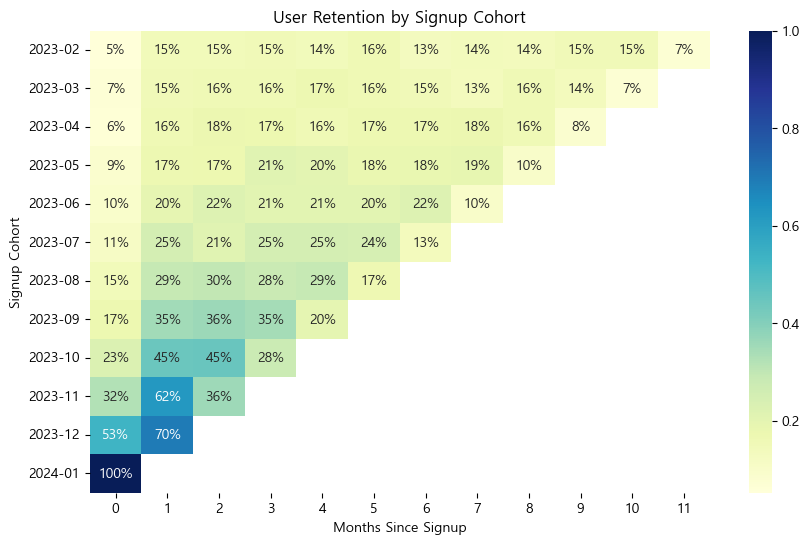

In [58]:
# 히트맵으로 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(retention_rates, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('User Retention by Signup Cohort')
plt.xlabel('Months Since Signup')
plt.ylabel('Signup Cohort')
plt.show()

In [59]:
def make_cohort_data(df, month = 12):
    cohort_data = df.groupby(['first_use_month', 'cohort_index'])['user_id'].nunique().reset_index()
    cohort_counts = cohort_data.pivot(index='first_use_month', columns='cohort_index', values='user_id')
    total_users_per_cohort = df.groupby(['first_use_month']).nunique()['user_id']
    retention_rates = cohort_counts.div(total_users_per_cohort, axis=0)
    retention_rates = retention_rates.iloc[-1 * month:, :month]
    return retention_rates
    

In [60]:
users_country = users[['id', 'country']]

In [61]:
users_country.columns = ['user_id', 'country']
events = events.merge(users_country, on='user_id')

In [62]:
events_US = events[events['country'] == 'United States']
events_KR = events[events['country'] == 'South Korea']
events_JP = events[events['country'] == 'Japan']


In [63]:
retention_rates_US = make_cohort_data(events_US)
retention_rates_KR = make_cohort_data(events_KR)
retention_rates_JP = make_cohort_data(events_JP)

<Figure size 2000x1600 with 0 Axes>

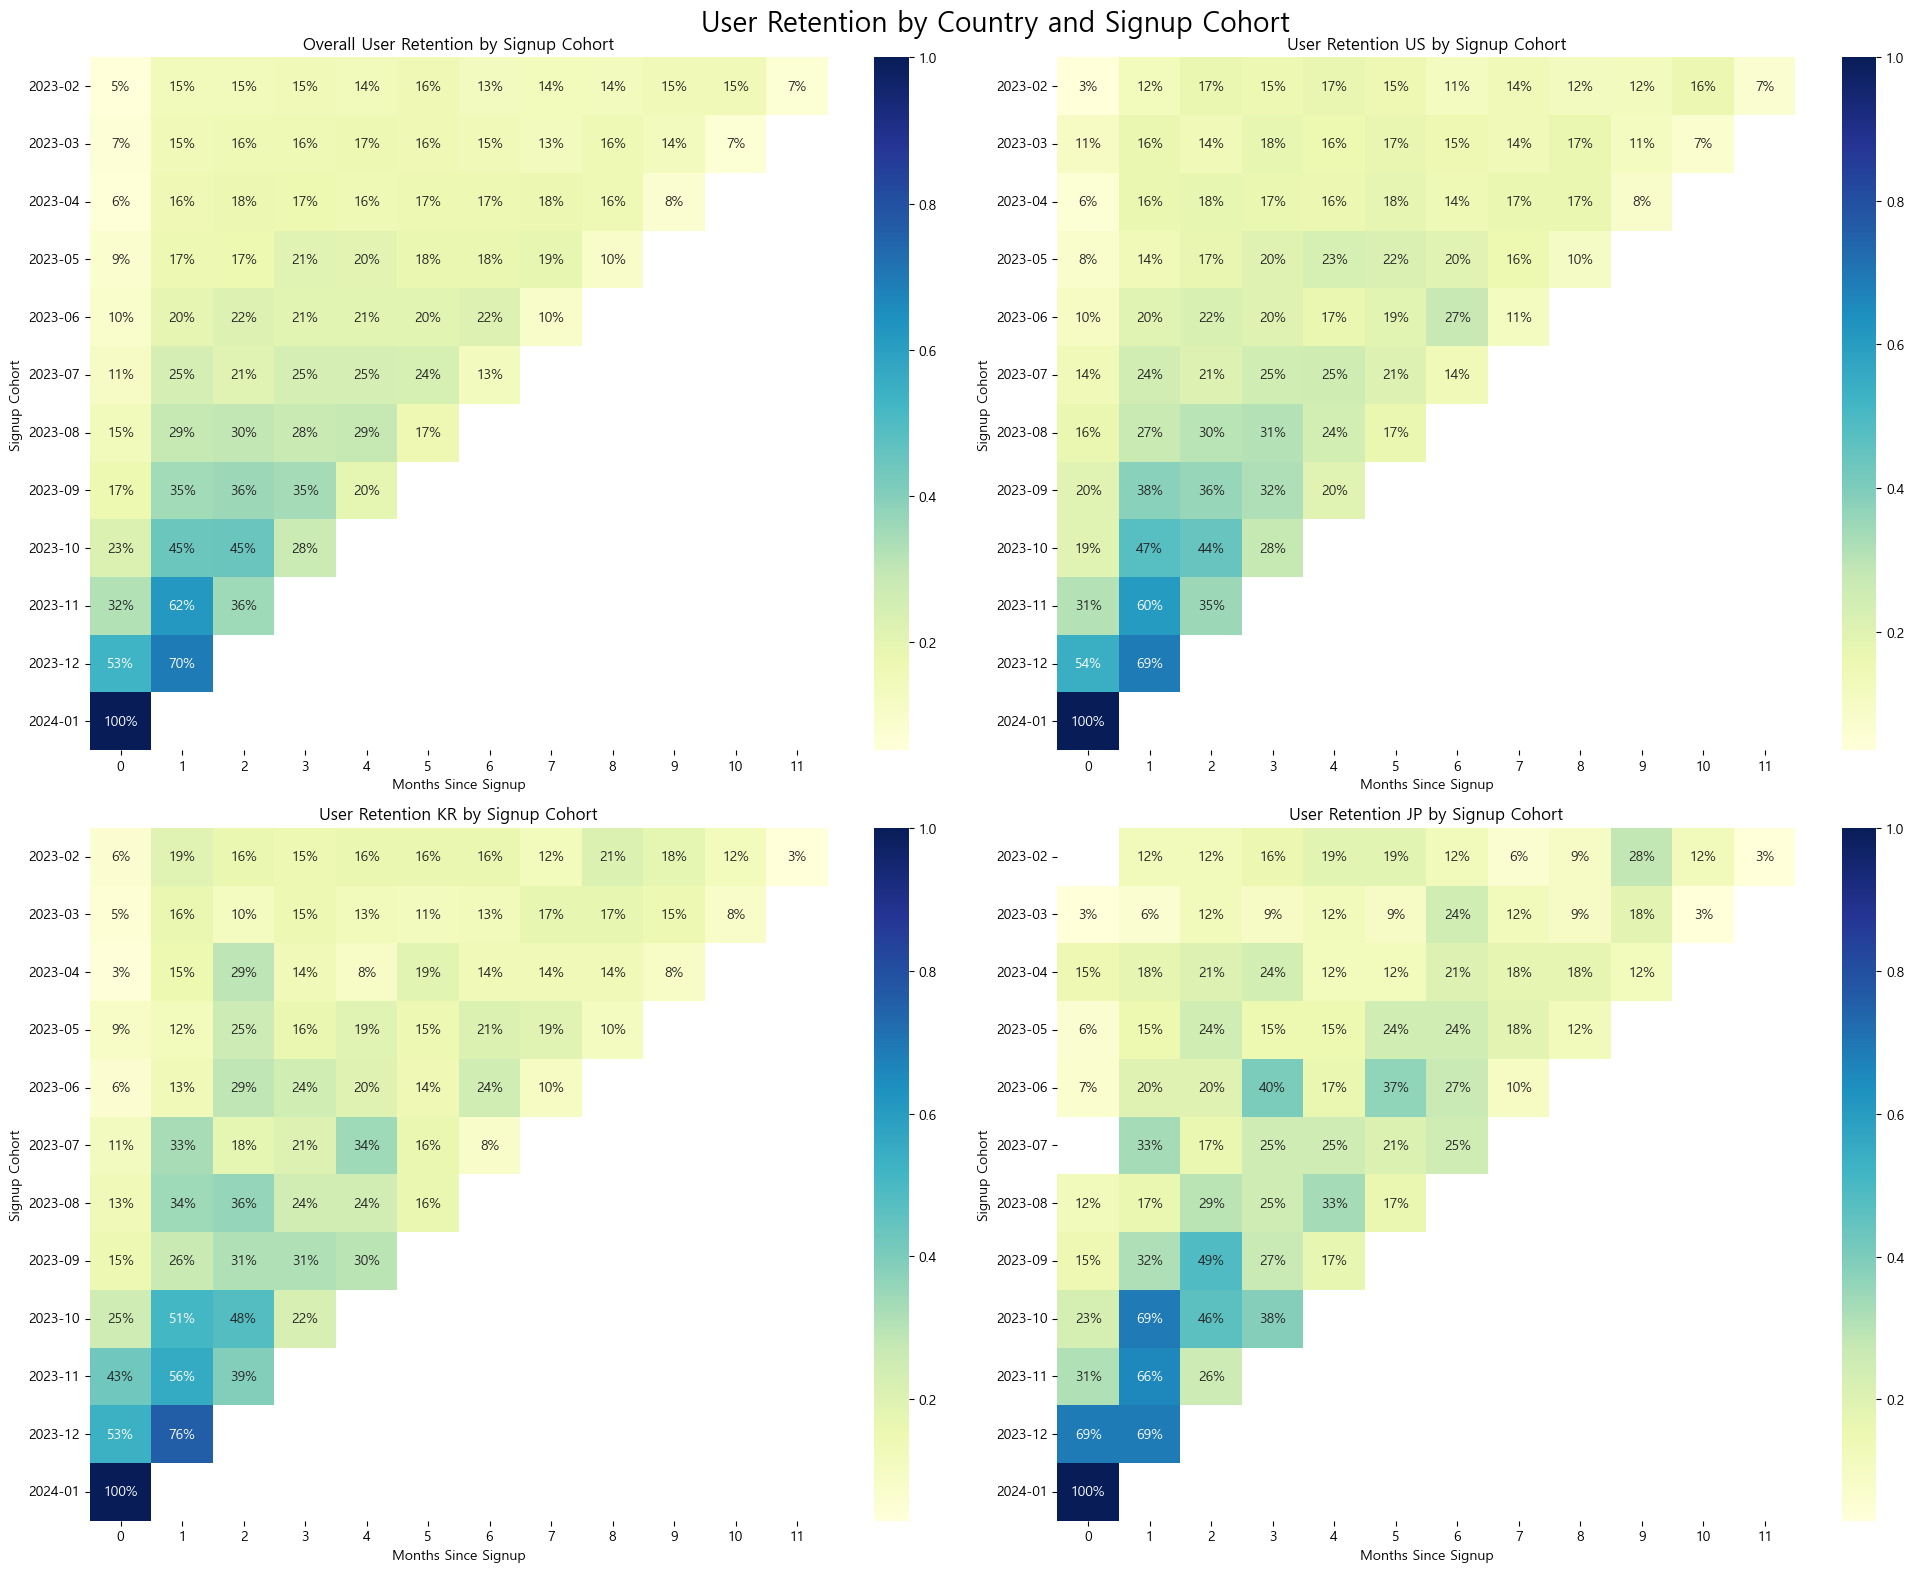

In [64]:
# 전체 figure 크기 설정
plt.figure(figsize=(20, 16))

# 2x2 서브플롯 생성
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 전체 데이터 히트맵
sns.heatmap(retention_rates, annot=True, fmt='.0%', cmap='YlGnBu', ax=ax1)
ax1.set_title('Overall User Retention by Signup Cohort')
ax1.set_xlabel('Months Since Signup')
ax1.set_ylabel('Signup Cohort')

# US 히트맵
sns.heatmap(retention_rates_US, annot=True, fmt='.0%', cmap='YlGnBu', ax=ax2)
ax2.set_title('User Retention US by Signup Cohort')
ax2.set_xlabel('Months Since Signup')
ax2.set_ylabel('Signup Cohort')

# KR 히트맵
sns.heatmap(retention_rates_KR, annot=True, fmt='.0%', cmap='YlGnBu', ax=ax3)
ax3.set_title('User Retention KR by Signup Cohort')
ax3.set_xlabel('Months Since Signup')
ax3.set_ylabel('Signup Cohort')

# JP 히트맵
sns.heatmap(retention_rates_JP, annot=True, fmt='.0%', cmap='YlGnBu', ax=ax4)
ax4.set_title('User Retention JP by Signup Cohort')
ax4.set_xlabel('Months Since Signup')
ax4.set_ylabel('Signup Cohort')

# 전체 타이틀 추가
plt.suptitle('User Retention by Country and Signup Cohort', fontsize=20)

# 서브플롯 간 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

### 클러스터링

In [66]:
complete_orders = pd.read_csv('data/complete_orders.csv')

In [67]:
events['created_at'].max()

Timestamp('2024-01-21 16:18:30+0000', tz='UTC')

#### 구매 관련 변수

In [69]:
# 사용자별 특성 추출
user_features = events.groupby('user_id').agg({
    'id': 'count',  # 총 이벤트 수
    'created_at': lambda x: (events['created_at'].max() - x.max()).days,  # 마지막 활동 이후 경과 일수 (2024-01-21 기준)
    'session_id': 'nunique',  # unique 세션 수
}).rename(columns={
    'id': 'total_events',
    'created_at': 'days_since_last_active',
    'session_id': 'total_sessions',
    # 'event_type': 'unique_event_types'
})


In [70]:
# 가입 후 경과 일수 변수 추가
user_features = user_features.join(users.set_index('id')['created_at'])
user_features['days_since_signup'] = (events['created_at'].max() - user_features['created_at']).dt.days
user_features = user_features.drop('created_at', axis=1)

In [71]:
user_features.head()

,total_events,days_since_last_active,total_sessions,days_since_signup
user_id,,,,
1.0,30,550,3,669
2.0,5,700,1,1189
3.0,29,166,5,318
4.0,5,460,1,1590
5.0,30,454,3,1206


In [72]:
complete_orders.head()

,Unnamed: 0,id_orderproducts,order_id,user_id_item,product_id_all,inventory_item_id,status_item,created_at_item,shipped_at_item,delivered_at_item,returned_at_item,sale_price,gender_orders,created_at_order,num_of_item,cost_all,category,name,brand,department,sku,distribution_center_id,created_at_orders,first_name_orders,last_name_orders,email_orders,age_orders,state_orders,street_address_orders,postal_code_orders,city_orders,country_orders,latitude_orders,longitude_orders,traffic_source_orders,created_at_user,product_cost,total_revenue,total_profit,year_month
0,1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaN,0.02,F,2023-03-14 03:59:00+00:00,1,0.0083,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,2023-06-05 15:24:00+00:00,Terri,Alvarez,terrialvarez@example.net,35,Jiangsu,5374 Courtney Parkway,215007,Yulin,China,31.278607,120.642997,Organic,2022-07-15 03:59:00+00:00,0.0083,0.02,0.0117,2023-03
1,2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaN,0.02,F,2023-12-03 13:23:00+00:00,4,0.0083,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,2020-04-12 14:36:00+00:00,Rebecca,Mcgee,rebeccamcgee@example.org,49,Texas,7187 Michael Forge Apt. 777,75604,Longview,United States,32.512434,-94.825486,Organic,2019-06-22 13:23:00+00:00,0.0332,0.08,0.0468,2023-12
2,3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaN,NaN,0.02,F,2023-12-23 00:17:00+00:00,4,0.0083,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,2020-01-24 05:47:00+00:00,Shelly,Rogers,shellyrogers@example.net,44,Hyogo,6970 Cherry Extension Apt. 442,675-0137,Kakogawa City,Japan,34.718505,134.825010,Search,2022-05-17 00:17:00+00:00,0.0332,0.08,0.0468,2023-12
3,4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaN,NaN,0.02,F,2022-06-17 17:21:00+00:00,3,0.0083,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,2022-09-13 16:58:00+00:00,Mariah,Stephens,mariahstephens@example.com,59,England,6522 Stephens Meadows Suite 475,LA1,Lancaster,United Kingdom,54.045973,-2.794106,Search,2021-06-23 17:21:00+00:00,0.0249,0.06,0.0351,2022-06
4,5,154022,106052,84693,14235,415780,Shipped,2023-09-19 09:13:08+00:00,2023-09-16 09:24:00+00:00,NaN,NaN,0.02,F,2023-09-15 12:39:00+00:00,2,0.0083,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,2022-01-06 14:25:00+00:00,Danielle,Bennett,daniellebennett@example.com,46,Maryland,4809 Michael Stream Apt. 104,20879,Montgomery Village,United States,39.170423,-77.175666,Search,2019-08-22 12:39:00+00:00,0.0166,0.04,0.0234,2023-09


In [73]:
order_features = complete_orders.groupby('user_id_item').agg({
    'order_id': 'nunique',  # 구매횟수
    'total_revenue': 'sum',  # 구매금액
}).rename(columns={
    'order_id': 'order_count',
    'total_revenue': 'total_revenue'
})

In [74]:
order_features['avg_revenue'] = order_features['total_revenue'] / order_features['order_count']

In [75]:
all_features = pd.merge(user_features, order_features, left_index = True, right_index = True, how = 'left')

"""
select *
from user_features A
left join order_features B
on A.index = B.index
;
"""

'\nselect *\nfrom user_features A\nleft join order_features B\non A.index = B.index\n;\n'

In [78]:
all_features.head()

,total_events,days_since_last_active,total_sessions,days_since_signup,order_count,total_revenue,avg_revenue
user_id,,,,,,,
1.0,30,550,3,669,1.0,479.969999,479.969999
2.0,5,700,1,1189,1.0,22.000000,22.000000
3.0,29,166,5,318,2.0,356.930000,178.465000
4.0,5,460,1,1590,1.0,148.000000,148.000000
5.0,30,454,3,1206,NaN,NaN,NaN


### 클러스터링 코드

In [87]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [91]:
all_features.isna().sum()

total_events                  0
days_since_last_active        0
total_sessions                0
days_since_signup             0
order_count               26518
total_revenue             26518
avg_revenue               26518
dtype: int64

In [95]:
all_features.fillna(0,inplace = True)

In [96]:
# 특성 정규화
scaler = StandardScaler()
features_scaled = scaler.fit_transform(all_features)

In [97]:
# 최적 클러스터 수 구하기
def compute_metrics(X, max_clusters=10):
    inertias = []
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    return inertias, silhouette_scores
# k-means 알고리즘에서 inertia(관성)는 각 데이터 포인트와 그 포인트가 속한 클러스터의 중심점 사이의 거리 제곱의 합을 의미합니다.
# 이는 클러스터 내 응집도를 측정하는 지표로 사용됩니다.

In [98]:
# 메트릭 계산
inertias, silhouette_scores = compute_metrics(features_scaled)

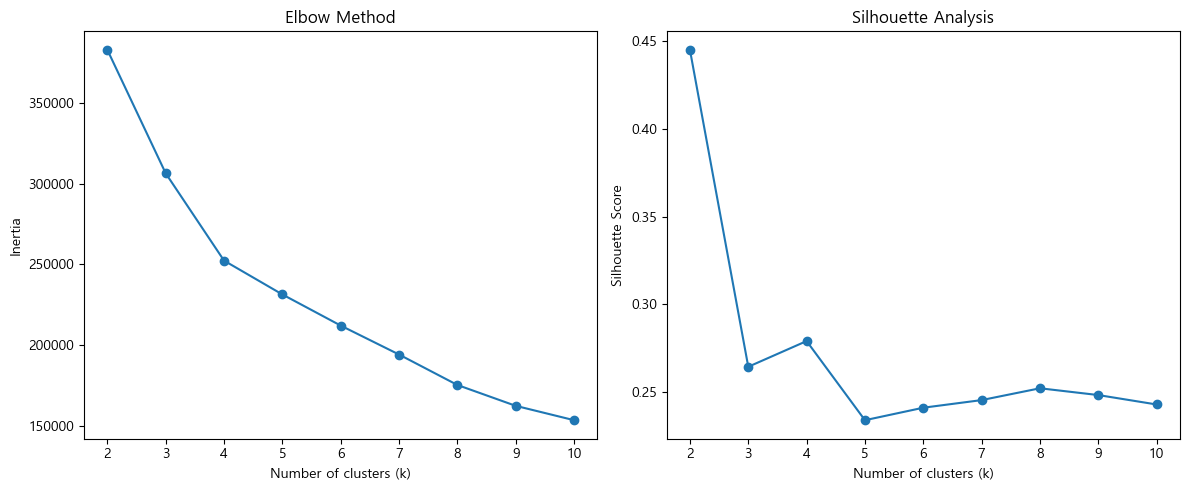

In [99]:
# 엘보우 방법 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, len(inertias) + 2), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# 실루엣 점수 시각화
plt.subplot(1, 2, 2)
plt.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()


In [100]:
# 최적의 클러스터 수로 K-means 재실행
kmeans_optimal = KMeans(n_clusters=4, random_state=42)
all_features['cluster'] = kmeans_optimal.fit_predict(features_scaled)

In [101]:
all_features.head()

,total_events,days_since_last_active,total_sessions,days_since_signup,order_count,total_revenue,avg_revenue,cluster
user_id,,,,,,,,
1.0,30,550,3,669,1.0,479.969999,479.969999,0
2.0,5,700,1,1189,1.0,22.000000,22.000000,2
3.0,29,166,5,318,2.0,356.930000,178.465000,0
4.0,5,460,1,1590,1.0,148.000000,148.000000,2
5.0,30,454,3,1206,0.0,0.000000,0.000000,2


In [102]:
# 클러스터별 차이점 파악
cluster_means = all_features.groupby('cluster').mean()

In [103]:
cluster_means

,total_events,days_since_last_active,total_sessions,days_since_signup,order_count,total_revenue,avg_revenue
cluster,,,,,,,
0,35.646236,235.502620,4.460494,902.910645,1.599559,246.478299,152.892113
1,9.012738,185.812961,1.560174,557.828406,0.643838,51.390096,48.202118
2,9.488695,757.085771,1.561270,1418.510186,0.636970,56.555783,53.363962
3,55.206878,349.842558,5.147501,937.020956,1.513702,1159.977193,884.178881


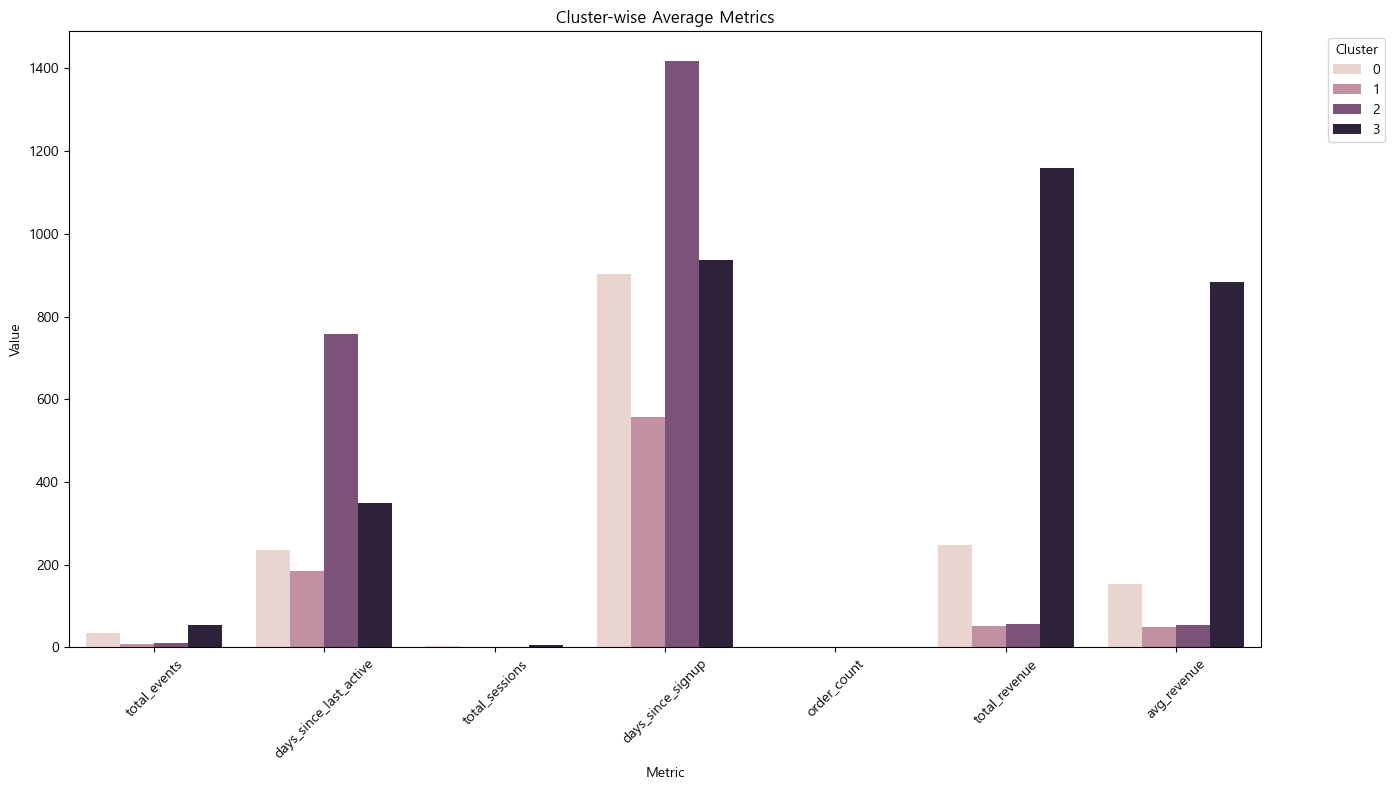

In [104]:

df_reset = cluster_means.reset_index()
df_melted = df_reset.melt(id_vars='cluster', var_name='Metric', value_name='Value')

plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Value', hue='cluster', data=df_melted)
plt.xticks(rotation=45)
plt.title('Cluster-wise Average Metrics')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3번 클러스터가 고매출(고래) 유저
# 0번은 3번보단 작지만 매출이 어느 정도 되는 유저
# 1, 2번은 둘 다 저매출이지만 가입 시기의 차이(1번은 최근 가입, 2번은 과거 가입)

In [105]:
# 클러스터별 사용자 수 
cluster_sizes = all_features['cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
cluster_sizes


Cluster Sizes:


cluster
0    14504
1    33993
2    25918
3     3722
Name: count, dtype: int64

#### t-sne를 활용한 시각화

In [106]:
from sklearn.manifold import TSNE

In [107]:
all_features.head()

,total_events,days_since_last_active,total_sessions,days_since_signup,order_count,total_revenue,avg_revenue,cluster
user_id,,,,,,,,
1.0,30,550,3,669,1.0,479.969999,479.969999,0
2.0,5,700,1,1189,1.0,22.000000,22.000000,2
3.0,29,166,5,318,2.0,356.930000,178.465000,0
4.0,5,460,1,1590,1.0,148.000000,148.000000,2
5.0,30,454,3,1206,0.0,0.000000,0.000000,2


In [108]:
# t-SNE 모델 생성 및 학습
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(all_features.drop(['cluster'], axis = 1))

# 결과를 데이터프레임으로 변환
tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['cluster'] = all_features['cluster']


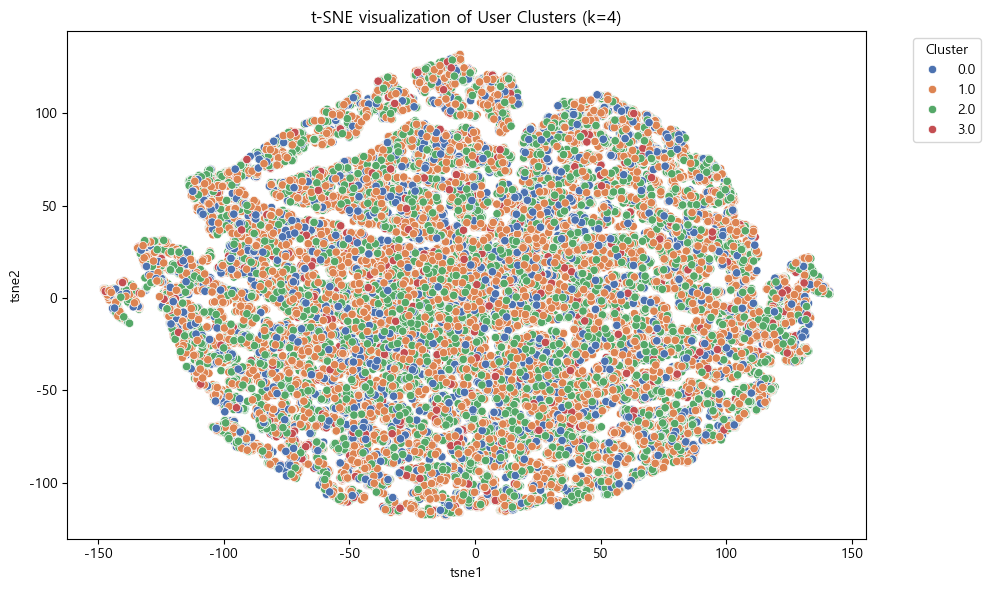

In [110]:
# t-SNE 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='cluster', palette='deep')
plt.title(f't-SNE visualization of User Clusters (k={4})')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [114]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # 95% of variance
pca_result = pca.fit_transform(features_scaled)

In [115]:
tsne_results = TSNE(n_components=2, random_state=42).fit_transform(pca_result)

In [116]:
# 결과를 데이터프레임으로 변환
tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['cluster'] = all_features['cluster']

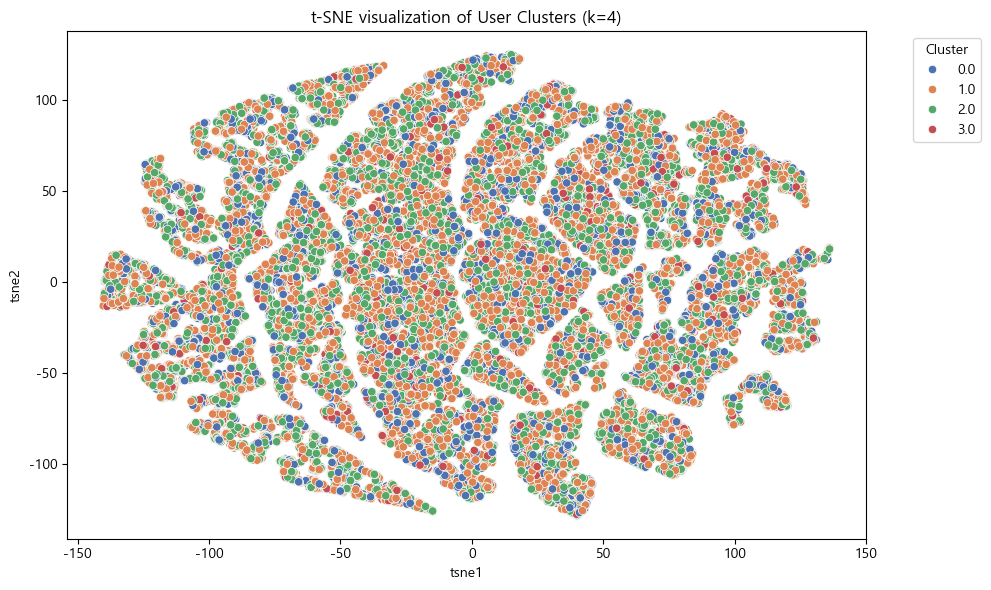

In [117]:
# t-SNE 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='cluster', palette='deep')
plt.title(f't-SNE visualization of User Clusters (k={4})')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [118]:
all_features

,total_events,days_since_last_active,total_sessions,days_since_signup,order_count,total_revenue,avg_revenue,cluster
user_id,,,,,,,,
1.0,30,550,3,669,1.0,479.969999,479.969999,0
2.0,5,700,1,1189,1.0,22.000000,22.000000,2
3.0,29,166,5,318,2.0,356.930000,178.465000,0
4.0,5,460,1,1590,1.0,148.000000,148.000000,2
5.0,30,454,3,1206,0.0,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...
99993.0,5,18,1,1189,0.0,0.000000,0.000000,1
99996.0,28,312,4,1483,0.0,0.000000,0.000000,2
99998.0,15,183,3,447,0.0,0.000000,0.000000,1


### 가설 검정

In [1]:
from scipy import stats

#### 평균 차이 검정_t-검정

In [77]:
all_features

,total_events,days_since_last_active,total_sessions,days_since_signup,order_count,total_revenue,avg_revenue
user_id,,,,,,,
1.0,30,550,3,669,1.0,479.969999,479.969999
2.0,5,700,1,1189,1.0,22.000000,22.000000
3.0,29,166,5,318,2.0,356.930000,178.465000
4.0,5,460,1,1590,1.0,148.000000,148.000000
5.0,30,454,3,1206,NaN,NaN,NaN
...,...,...,...,...,...,...,...
99993.0,5,18,1,1189,NaN,NaN,NaN
99996.0,28,312,4,1483,NaN,NaN,NaN
99998.0,15,183,3,447,NaN,NaN,NaN


In [79]:
users[['id', 'country']]

,id,country
0,457,Brasil
1,6578,Brasil
2,36280,Brasil
3,60193,Brasil
4,64231,Brasil
...,...,...
99995,93247,France
99996,59110,France
99997,57045,France
99998,73312,France


In [80]:
#국가 추가
all_features = pd.merge(all_features, users[['id', 'country']], left_index = True, right_on = 'id').drop('id', axis = 1)
''' -- SQL

select A.*
     , B.country
from all_features A
left join users B 
on A.user_id = B.id
'''

' -- SQL\n\nselect A.*\n     , B.country\nfrom all_features A\nleft join users B \non A.user_id = B.id\n'

In [81]:
all_features.head()

,total_events,days_since_last_active,total_sessions,days_since_signup,order_count,total_revenue,avg_revenue,country
36920,30,550,3,669,1.0,479.969999,479.969999,South Korea
86998,5,700,1,1189,1.0,22.000000,22.000000,Brasil
25165,29,166,5,318,2.0,356.930000,178.465000,United States
88815,5,460,1,1590,1.0,148.000000,148.000000,United States
72216,30,454,3,1206,NaN,NaN,NaN,Brasil


In [90]:
all_features.fillna(0, inplace = True)

In [92]:
# 미국과 중국 데이터 필터링
us_data = all_features[all_features['country'] == 'United States']['total_revenue']
china_data = all_features[all_features['country'] == 'China']['total_revenue']

In [95]:
# 정규성 검정 (Shapiro-Wilk test) 모수가 커서 샤피로 테스트 안해도 됨
_, p_value_us = stats.shapiro(us_data)
_, p_value_china = stats.shapiro(china_data)

C:\Users\hyunj\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17545.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\hyunj\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26736.
  res = hypotest_fun_out(*samples, **kwds)


In [98]:
# 등분산성 검정 (Levene's test) 
_, p_value_levene = stats.levene(us_data, china_data)
print(f"\n등분산성 검정 p-값: {p_value_levene:.4f}")


등분산성 검정 p-값: 0.2096


In [99]:
# 독립표본 t-검정
t_statistic, p_value_t = stats.ttest_ind(us_data, china_data)


In [101]:
print("\n검정 결과:")
print(f"독립표본 t-검정 p-값: {p_value_t:.4f}")


검정 결과:
독립표본 t-검정 p-값: 0.2053


In [102]:

# 결과 해석
alpha = 0.05
if p_value_t < alpha:
    print("\nt-검정 결과: 미국과 중국의 총 수익에 통계적으로 유의한 차이가 있습니다.")
else:
    print("\nt-검정 결과: 미국과 중국의 총 수익에 통계적으로 유의한 차이가 없습니다.")




t-검정 결과: 미국과 중국의 총 수익에 통계적으로 유의한 차이가 없습니다.


#### ANOVA - 3집단 이상일 때, 평균 차이를 검정

In [108]:
countries = ['United States', 'China', 'South Korea']
df_filtered = all_features[all_features['country'].isin(countries)]

In [103]:
# 귀무가설: 3집단 평균 차이가 없다.
# 대립가설: 3집단 중 하나 이상에 평균 차이가 있다.

In [104]:
# 한미중 데이터 필터링
us_data = all_features[all_features['country'] == 'United States']['total_revenue']
china_data = all_features[all_features['country'] == 'China']['total_revenue']
korean_data = all_features[all_features['country'] == 'South Korea']['total_revenue']

In [105]:
f_statistic, p_value = stats.f_oneway(
    all_features[all_features['country'] == 'United States']['total_revenue'],
    all_features[all_features['country'] == 'China']['total_revenue'],
    all_features[all_features['country'] == 'South Korea']['total_revenue']
)

In [106]:

print("\nANOVA 결과:")
print(f"F-통계량: {f_statistic}")
print(f"p-값: {p_value}")

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print("\nANOVA 결과: 세 국가의 총 수익에 통계적으로 유의한 차이가 있습니다.")
else:
    print("\nANOVA 결과: 세 국가의 총 수익에 통계적으로 유의한 차이가 없습니다.")


ANOVA 결과:
F-통계량: 0.9377208928701434
p-값: 0.39152623891644556

ANOVA 결과: 세 국가의 총 수익에 통계적으로 유의한 차이가 없습니다.


In [1]:
# 시각화: 박스플롯
plt.figure(figsize=(12, 6))
sns.boxplot(x='country', y='total_revenue', data=df_filtered)
plt.title('국가별 평균 구매 금액 분포')
plt.yscale('log')  # 로그 스케일 사용 (데이터 범위가 넓을 경우)
plt.ylabel('평균 구매 금액 (로그 스케일)')
plt.show()

NameError: name 'plt' is not defined

#### 카이제곱 검정
* 적합도 검정: 각 그룹별 비율과 특정 상수비가 같은지 검정
* 동질성 검정: 두 개 이상 집단의 분포가 동일한지 검정
* 독립성 검정: 두 개 이상의 변수가 서로 독립인지 검정

In [113]:
#여기서는 동질성 검정
# 서로 다른 5개의 집단(traffic_source에 대해 검정)

In [117]:
traffic_source_funnel = perform_funnel_analysis(events, 'traffic_source')

In [139]:
traffic_source_funnel['not_conversed'] = traffic_source_funnel['product'] - traffic_source_funnel['purchase']

In [140]:
traffic_source_funnel

event_type,product,cart,purchase,product_to_cart,cart_to_purchase,overall_conversion,not_conversed
traffic_source,,,,,,,
Adwords,254290,179281,54542,0.705026,0.304226,0.214487,199748
Email,379736,267411,81706,0.704202,0.305545,0.215165,298030
Facebook,84523,59962,18305,0.709416,0.305277,0.216568,66218
Organic,42520,29822,9124,0.701364,0.305949,0.214581,33396
YouTube,84538,59518,18082,0.704038,0.303807,0.213892,66456


In [141]:
# 관측 빈도 행렬 생성
observed = np.array([traffic_source_funnel['purchase'], traffic_source_funnel['not_conversed']])

In [142]:
observed

array([[ 54542,  81706,  18305,   9124,  18082],
       [199748, 298030,  66218,  33396,  66456]], dtype=int64)

In [143]:
# 카이제곱 검정 수행
chi2, p_value, dof, expected = stats.chi2_contingency(observed)

In [144]:
print("카이제곱 검정 결과:")
print(f"카이제곱 통계량: {chi2}")
print(f"p-값: {p_value}")
print(f"자유도: {dof}")

카이제곱 검정 결과:
카이제곱 통계량: 2.333451044548806
p-값: 0.6746856027745347
자유도: 4


In [149]:
traffic_source_funnel.reset_index(inplace = True)

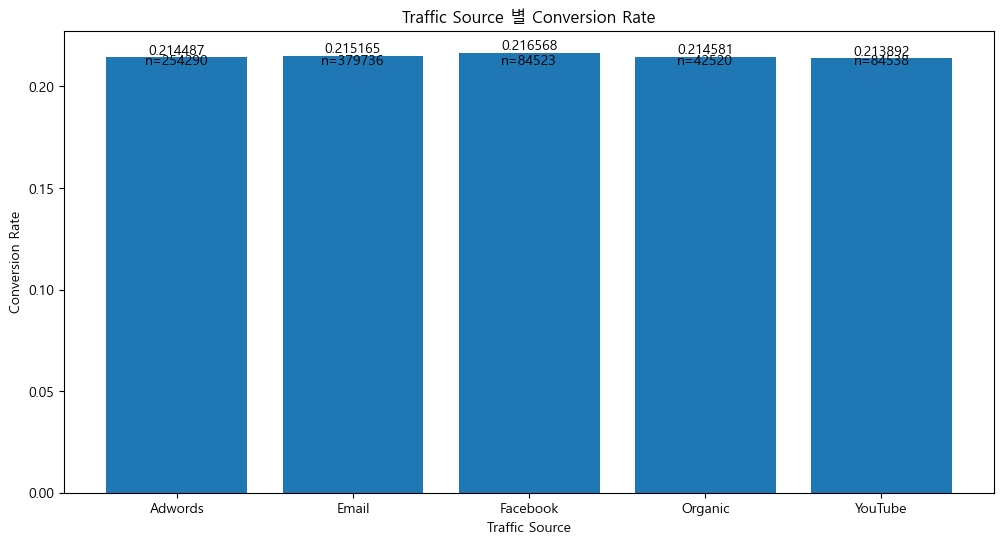

In [150]:
# 시각화: 바 플롯
plt.figure(figsize=(12, 6))
bars = plt.bar(traffic_source_funnel['traffic_source'], traffic_source_funnel['overall_conversion'])
plt.title('Traffic Source 별 Conversion Rate')
plt.xlabel('Traffic Source')
plt.ylabel('Conversion Rate')
# plt.ylim(0.21, 0.22)  # Y축 범위 설정

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.6f}',
             ha='center', va='bottom')

# 표본 크기 표시
for i, v in enumerate(traffic_source_funnel['product']):
    plt.text(i, 0.211, f'n={v}', ha='center')